In [1]:
from openslide import OpenSlide
import os
import numpy as np
import xml.etree.ElementTree as ET
import scipy
import pandas as pd
from matplotlib import pyplot as plt
import cv2
from time import time
from rgb2hed_v1 import separate_stains
from skimage.measure import label,find_contours,regionprops,regionprops_table
from skimage.morphology import remove_small_objects
from sklearn.neighbors import NearestNeighbors
from joblib import Parallel, delayed, cpu_count

In [2]:
# xml_path = absolute filepath of xml
# mdict = 2D coordinates of annotation by class and object
def readxml(xml_path):
    start = time()
    tree = ET.parse(xml_path)
    root = tree.getroot()
    x = np.array([])
    y = np.array([])
    obj = np.array([])
    classID = np.array([])
    for Annotation in root.iter('Annotation'):
      for Region in Annotation.iter('Region'):
         xx = np.array([int(Vertex.get('X')) for Vertex in Region.iter('Vertex')])
         yy = np.array([int(Vertex.get('Y')) for Vertex in Region.iter('Vertex')])
         objj = np.array([int(Region.get('Id'))]*len(xx))
         classIDD = np.array([int(Annotation.get('Id'))]*len(xx))
         x = np.concatenate((x,xx),axis=None)
         y = np.concatenate((y,yy),axis=None)
         obj = np.concatenate((obj,objj),axis=None)
         classID = np.concatenate((classID,classIDD),axis=None)
    # print('number of coordinates in annotation : ',len(x))
    mdict = {'x':x.astype(int),'y':y.astype(int),'objID':obj.astype(int),'classID':classID.astype(int)}
    print('readxml took {:.2f} sec'.format(time()-start))
    return pd.DataFrame(mdict)

In [3]:
# open svs and xml
svs_src = r'\\kukissd\research\aging\data\svs'
fn = 'Wirtz.Denis_OTS-19_5021-006'
svs_path = os.path.join(*[svs_src,fn+'.svs'])
xml_path = os.path.join(*[svs_src,fn+'.xml'])
if os.path.exists(svs_path): svs = OpenSlide(svs_path)
if os.path.exists(xml_path): xml = readxml(xml_path)
svs.level_dimensions

readxml took 1.29 sec


((80885, 46423), (20221, 11605), (5055, 2901), (2527, 1450))

In [4]:
obj_count_per_class = [len(np.unique(xml['objID'][xml['classID']==classid])) for classid in np.unique(xml['classID'])]
sort_index = np.argsort(obj_count_per_class)
# first element in this list is collagen index
sort_index

array([1, 0], dtype=int64)

In [5]:
# find reticular dermis of each section
start = time()
mask = np.zeros(svs.level_dimensions[-1][::-1])
for classidx, classid in enumerate(np.unique(xml['classID'])[sort_index]):
    for objidx, objid in enumerate(np.unique(xml['objID'])):
        object = xml[xml['classID']==classid][xml['objID']==objid]
        if len(object)<1: continue
        x = object['x']/svs.level_downsamples[-1]
        y = object['y']/svs.level_downsamples[-1]
        vertex = np.array([[i,j] for i,j in zip(x,y)]).astype(np.int32)
        cv2.fillPoly(mask,[vertex],color=int(classid-1))
print("mask generation: {:.2f} sec elapsed".format(time()-start))

c:\users\kuki\anaconda3\envs\tf21\lib\site-packages\ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


mask generation: 4.37 sec elapsed


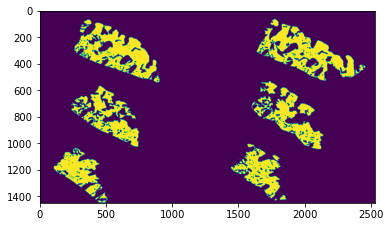

In [6]:
plt.imshow(mask)

In [7]:
# iterate each collagen (which is supposedly entire reticular dermis of a section)
for objidx, objid in enumerate(np.unique(xml['objID'])[0:1]):
    object = xml[xml['classID']==np.unique(xml['classID'])[sort_index][0]][xml['objID']==objid]
    x = object['x']
    y = object['y']
    [xmin,xmax,ymin,ymax] = [np.min(x),np.max(x),np.min(y),np.max(y)]
    [width,height] = [xmax-xmin,ymax-ymin]
    start=time()
    region = svs.read_region(location=(xmin,ymin),level=0,size=(width,height)).convert("RGB")
    print("openslide: {:.2f} sec elapsed".format(time()-start))
    start=time()
    [xmin_small,xmax_small,ymin_small,ymax_small] = [np.around(_/svs.level_downsamples[-1]).astype(int)
                                                     for _ in [xmin,xmax,ymin,ymax]]
    region_mask = mask[ymin_small:ymax_small,xmin_small:xmax_small]
    region_mask = cv2.resize(region_mask, dsize=region.size, interpolation=cv2.INTER_CUBIC)
    ret,region_mask = cv2.threshold(region_mask,0.5,1,cv2.THRESH_BINARY)
    region_mask = np.repeat(region_mask[:, :, np.newaxis], 3, axis=2)
    region = np.array(region).astype(np.float32)
    region[region_mask==0] = 255
    region = region/255
    print("masking: {:.2f} sec elapsed".format(time()-start))

c:\users\kuki\anaconda3\envs\tf21\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


openslide: 33.44 sec elapsed


MemoryError: Unable to allocate 6.91 GiB for an array with shape (15066, 20515, 3) and data type float64

In [ ]:
start=time()
plt.imshow(region.astype(np.float32))
print("plotting: {:.2f} sec elapsed".format(time()-start))

In [ ]:
# RGB to Haematoxylin-Eosin-DAB (HED) color space conversion.
# Hematoxylin + Eosin + DAB
start=time()
rgb_from_hed = np.array([[0.650, 0.704, 0.286],
                         [0.072, 0.990, 0.105],
                         [0.268, 0.570, 0.776]])
hed_from_rgb = scipy.linalg.inv(rgb_from_hed)
ihc_hed = separate_stains(region, hed_from_rgb)
Hema = ihc_hed[:, :, 0]
print("color deconvolution: {:.2f} sec elapsed".format(time()-start))

In [ ]:
# remove this for production mode #######################
fig, axes = plt.subplots(1, 2, figsize=(18, 6), sharex=True, sharey=True)
ax = axes.ravel()
ax[0].imshow(region[2000:4000,2000:4000])
ax[0].set_title("Original image")

ax[1].imshow(Hema[2000:4000,2000:4000], cmap='gray')
ax[1].set_title("ED")

for a in ax.ravel():
    a.axis('off')

fig.tight_layout()

In [ ]:
#1 intensity thresholding
threshold = 0.35
Hematoxylin = cv2.normalize(Hema, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
np.save(fn+'_H.npy',Hematoxylin)
# Hematoxylin = np.load(fn+'_H.npy')
# plt.imshow(Hematoxylin)
Hematoxylin[Hematoxylin<threshold]=0
Hematoxylin[Hematoxylin>threshold]=1
labeled_bw = label(Hematoxylin).astype(np.uint8)

In [ ]:
# plt.imshow(labeled_bw)
fig,ax=plt.subplots(1,2,figsize=(20,10))
ax[0].imshow(region.astype(np.float32)[2000:4000,2000:4000],cmap='gray')
a= (labeled_bw>0)*1
ax[1].imshow(a[2000:4000,2000:4000],cmap='gray')

In [ ]:
#pre-size filter
start=time()
remove_small_objects(labeled_bw,min_size=50,connectivity=1,in_place=True)
print("{:.2f} sec elapsed".format(time()-start))

In [ ]:
# before size filter
start=time()
prop = regionprops(labeled_bw)
area = [np.sum(x._label_image[x._slice] == x.label) for x in prop]
print("{:.2f} sec elapsed".format(time()-start))

In [ ]:
# before size filter
start=time()
prop2 = regionprops(labeled_bw)
area2 = Parallel(n_jobs=-4, prefer="threads")(delayed(np.sum)(x._label_image[x._slice] == x.label) for x in prop2)
print("{:.2f} sec elapsed".format(time()-start))

In [42]:
#2 size filter
start=time()
remove_small_objects(labeled_bw,min_size=50,connectivity=1,in_place=True)
print(time()-start,'sec elapsed')

2.257965087890625 sec elapsed


In [25]:
# before AR filter
# ARs = [_['major_axis_length']/_['minor_axis_length'] for _ in prop]
# plt.hist(ARs)
# plt.title('Aspect Ratio',fontsize=30)

start=time()
prop2 = regionprops(labeled_bw)
def regionar(x):
    return x['major_axis_length']/x['minor_axis_length']
ARs = Parallel(n_jobs=-4, prefer="threads")(delayed(regionar)(x) for x in prop2)
print("{:.2f} sec elapsed".format(time()-start))

MemoryError: Unable to allocate 2.23 GiB for an array with shape (14777, 20224) and data type float64

In [ ]:
plt.hist(ARs)
plt.title('Aspect Ratio',fontsize=30)

In [ ]:
#3 AR filter
minAR = 2
maxAR = 100
for prop in regionprops(labeled_bw):
    AR = prop['major_axis_length']/prop['minor_axis_length']
    if AR<minAR: labeled_bw[labeled_bw==prop.label]=0
    if AR>maxAR: labeled_bw[labeled_bw==prop.label]=0

In [131]:
#3 AR filter
minAR = 2
maxAR = 100
for prop in regionprops(labeled_bw):
    AR = prop['major_axis_length']/prop['minor_axis_length']
    if AR<minAR: labeled_bw[labeled_bw==prop.label]=0
    if AR>maxAR: labeled_bw[labeled_bw==prop.label]=0

Text(0.5, 1.0, 'Aspect Ratio')

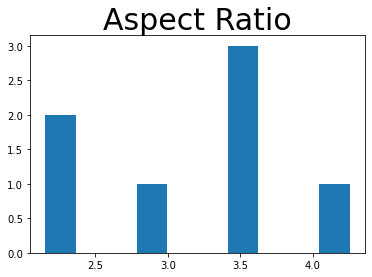

In [132]:
# after AR filter
prop = regionprops(labeled_bw)
ARs = [_['major_axis_length']/_['minor_axis_length'] for _ in prop]
plt.hist(ARs)
plt.title('Aspect Ratio',fontsize=30)

Text(0.5, 1.0, 'Circularity')

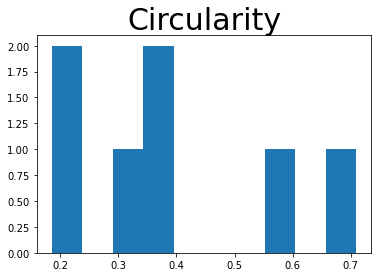

In [135]:
# before SF filter
SFs = [4*np.pi*_['area']/_['perimeter']**2 for _ in prop]
plt.hist(SFs)
plt.title('Circularity',fontsize=30)


In [138]:
#4 SF filter
minSF = 0.1
maxSF = 0.6
for prop in regionprops(labeled_bw):
    SF = 4*np.pi*prop['area']/prop['perimeter']**2
    if SF<minSF: labeled_bw[labeled_bw==prop.label]=0; print(prop.label)
    if SF>maxSF: labeled_bw[labeled_bw==prop.label]=0; print(prop.label)

[ 0  2  6  8 60 90]
[ 0  2  6  8 60 90]


(array([2., 0., 0., 0., 0., 1., 0., 0., 0., 2.]),
 array([0.18592022, 0.2065704 , 0.22722058, 0.24787076, 0.26852094,
        0.28917112, 0.3098213 , 0.33047148, 0.35112167, 0.37177185,
        0.39242203]),
 <BarContainer object of 10 artists>)

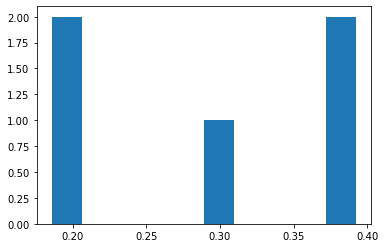

In [140]:
# after SF filter
prop = regionprops(labeled_bw)
SFs = [4*np.pi*_['area']/_['perimeter']**2 for _ in prop]
plt.hist(SFs)
plt.title('Circularity',fontsize=30)

[(15.439716312056738, 256.6595744680851),
 (30.464912280701753, 338.0438596491228),
 (39.440677966101696, 250.96610169491527),
 (119.12328767123287, 352.3013698630137),
 (185.7967032967033, 42.1978021978022)]

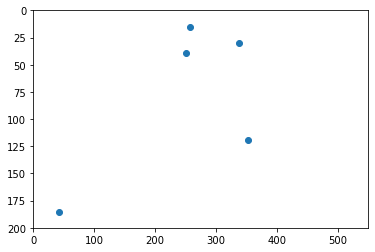

In [198]:
#distance filter
min_dist_to_neighbor = 50
Y = [_.centroid for _ in prop]
nbrs = NearestNeighbors(n_neighbors=2, algorithm='ball_tree').fit(Y)
distances, indices = nbrs.kneighbors(Y)
close_objects = np.array(prop)[distances[:,1]<min_dist_to_neighbor]
for close_object in close_objects:
    labeled_bw[labeled_bw==close_object.label]=0
